In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anndata
from scipy.stats import binom
from itertools import permutations
import sklearn.metrics



plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Comparison of different weight methods

In [2]:
AML_S2_patients = np.array(["P"+str(i) for i in np.arange(1, 5)])
AML_10X_patients = np.array(["A"+str(i) for i in np.arange(1, 16)])
LUNG_patients = ["p018", "p019", "p023", "p030", "p031","p032", "p033"]
CRC_patients = ["p007", "p013", "p014", "p016", "p020", "p026"]

all_patients = np.concatenate([AML_S2_patients, AML_10X_patients, LUNG_patients, CRC_patients])

In [3]:
all_adata = []
for p in all_patients:
    path = "../processed_data//" 
    path += "AML_MutaSeq/" if p in AML_S2_patients else "AML_10X/" if p in AML_10X_patients else "LUNG/" if p in LUNG_patients else "CRC/"
    all_adata.append(anndata.read_h5ad(path+p+".h5ad"))
    

In [4]:
def get_10X_weights(adata):
    weights_10X = np.zeros(adata.X.shape)
    for i in np.unique(adata.X):
        p = 1 - binom.pmf(k=0, n=i, p=.5) 
        weights_10X[np.where(adata.X == i)] = p
    weights_10X[adata.layers["M"] == 0.5] = 1  
    weights_10X[np.where(adata.X < 2)] = 0 
    return weights_10X

def get_S2_weights(adata):
    weights_S2 = np.zeros(adata.X.shape)
    weights_S2[np.where(adata.X >= 2)] = 0.5
    weights_S2[adata.layers["M"] == 0.5] = 1
    return weights_S2

def get_binary_weights(adata):
    weights_binary = np.ones(adata.X.shape)
    weights_binary[np.where(adata.X < 2)] = 0
    return weights_binary

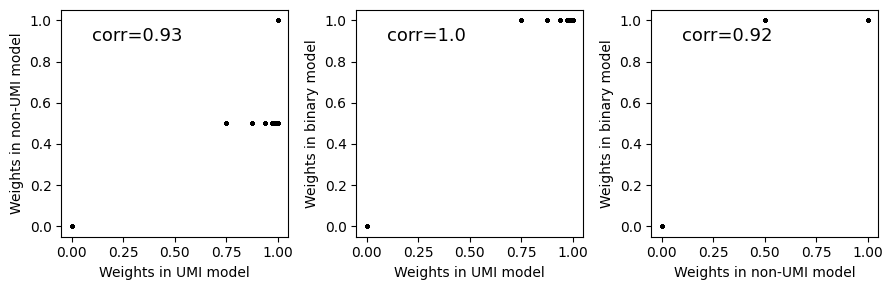

In [21]:
adata = all_adata[np.where(all_patients=="P1")[0][0]]

weights_10X = get_10X_weights(adata)
weights_S2 = get_S2_weights(adata)
weights_binary = get_binary_weights(adata)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
x, y = weights_10X.flatten(), weights_S2.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
axs[0].scatter(x, y, alpha=.01, s=5, c="black")
axs[0].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[0].set_xlabel("Weights in UMI model")
axs[0].set_ylabel("Weights in non-UMI model")

x, y = weights_10X.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
axs[1].scatter(x, y, alpha=.01, s=5, c="black")
axs[1].annotate("corr="+str(corr), (.1,.9), fontsize=13)
axs[1].set_xlabel("Weights in UMI model")
axs[1].set_ylabel("Weights in binary model")

x, y = weights_S2.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
axs[2].scatter(x, y, alpha=.01, s=5, c="black")
axs[2].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[2].set_xlabel("Weights in non-UMI model")
axs[2].set_ylabel("Weights in binary model")
plt.tight_layout()
plt.show()

In [31]:
def get_density(x, y):
    x_, y_, c = [],[], []
    for i in np.unique(x):
        for j in np.unique(y):

            sm = np.sum((x==i) &(y== j))
            if sm>0:
                x_.append(i), y_.append(j)
                c.append(sm)
    return x_, y_, c

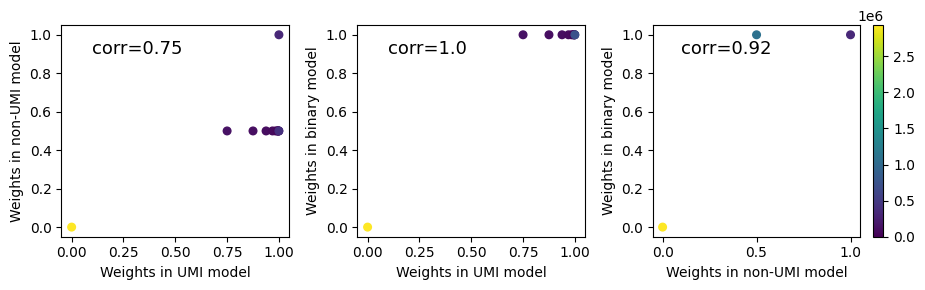

In [105]:
adata = all_adata[np.where(all_patients=="P1")[0][0]]

weights_10X = get_10X_weights(adata)
weights_S2 = get_S2_weights(adata)
weights_binary = get_binary_weights(adata)

mx = np.sum(weights_binary==0)

fig, axs = plt.subplots(1, 3, figsize=(9.4, 3), width_ratios=(3, 3, 3.4))
x, y = weights_10X.flatten(), weights_S2.flatten()
x, y, c = get_density(np.round(x,3), y)
axs[0].scatter(x, y, s=30, c=c,cmap="viridis", vmin=0, vmax=mx)
corr = np.round(np.corrcoef(x,y)[0,1], 2)
axs[0].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[0].set_xlabel("Weights in UMI model")
axs[0].set_ylabel("Weights in non-UMI model")
#axs[0].

x, y = weights_10X.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
x, y, c = get_density(np.round(x,3), y)
axs[1].scatter(x, y, s=30, c=c,cmap="viridis", vmin=0, vmax=mx)
axs[1].annotate("corr="+str(corr), (.1,.9), fontsize=13)
axs[1].set_xlabel("Weights in UMI model")
axs[1].set_ylabel("Weights in binary model")

x, y = weights_S2.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
x, y, c = get_density(x, y)
psm = axs[2].scatter(x, y, s=30, c=c, cmap="viridis",vmin=0, vmax=mx)
axs[2].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[2].set_xlabel("Weights in non-UMI model")
axs[2].set_ylabel("Weights in binary model")
fig.colorbar(psm)
plt.tight_layout()

plt.savefig("../figures/S4_weight_correlation_P1.pdf", dpi=300)

In [95]:
weights_10X.shape, adata.shape
#mx, x, y, c
#weights_S2.ravel().shape, mx, weights_S2.shape[0]*weights_S2.shape[1]#, weights_binary.flatten()

((4065, 219), (4065, 219))

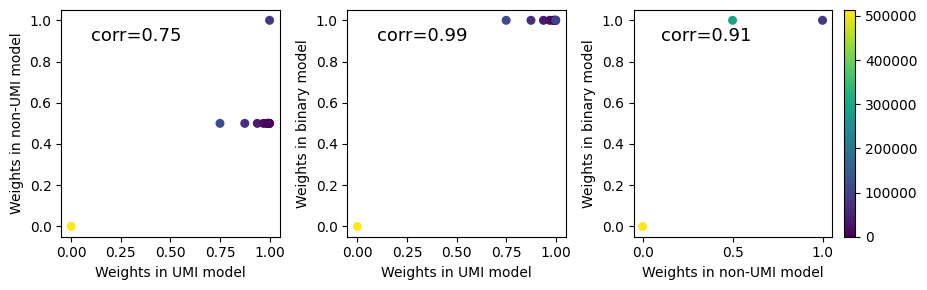

In [104]:
adata = all_adata[np.where(all_patients=="A1")[0][0]]

weights_10X = get_10X_weights(adata)
weights_S2 = get_S2_weights(adata)
weights_binary = get_binary_weights(adata)

mx = np.sum(weights_binary==0)

fig, axs = plt.subplots(1, 3, figsize=(9.4, 3), width_ratios=(3, 3, 3.4))
x, y = weights_10X.flatten(), weights_S2.flatten()
x, y, c = get_density(np.round(x,3), y)
axs[0].scatter(x, y, s=30, c=c,cmap="viridis", vmin=0, vmax=mx)
corr = np.round(np.corrcoef(x,y)[0,1], 2)
axs[0].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[0].set_xlabel("Weights in UMI model")
axs[0].set_ylabel("Weights in non-UMI model")
#axs[0].

x, y = weights_10X.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
x, y, c = get_density(np.round(x,3), y)
axs[1].scatter(x, y, s=30, c=c,cmap="viridis", vmin=0, vmax=mx)
axs[1].annotate("corr="+str(corr), (.1,.9), fontsize=13)
axs[1].set_xlabel("Weights in UMI model")
axs[1].set_ylabel("Weights in binary model")

x, y = weights_S2.flatten(), weights_binary.flatten()
corr = np.round(np.corrcoef(x,y)[0,1], 2)
x, y, c = get_density(x, y)
psm = axs[2].scatter(x, y, s=30, c=c, cmap="viridis",vmin=0, vmax=mx)
axs[2].annotate("corr="+str(corr), (.1,.9), fontsize=13) 
axs[2].set_xlabel("Weights in non-UMI model")
axs[2].set_ylabel("Weights in binary model")
fig.colorbar(psm)
plt.tight_layout()

plt.savefig("../figures/S4_weight_correlation_A1.pdf", dpi=300)

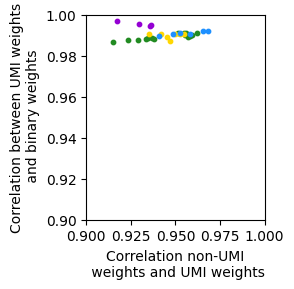

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i, p in enumerate(all_patients):
    adata = all_adata[i]
    color = "darkviolet" if p in AML_S2_patients else "forestgreen" if p in AML_10X_patients else "gold" if p in LUNG_patients else "dodgerblue"

    weights_10X = get_10X_weights(adata)
    weights_S2 = get_S2_weights(adata)
    x = np.corrcoef(weights_10X.flatten(), weights_S2.flatten())[0,1]
    
    weights_binary = get_binary_weights(adata)
    y = np.corrcoef(weights_10X.flatten(), weights_binary.flatten())[0,1]

    ax.scatter(x, y, marker="o", s=10, c=color)
    
plt.xlim(.9,1)
plt.ylim(.9,1)
plt.xlabel("Correlation non-UMI\n weights and UMI weights")
plt.ylabel("Correlation between UMI weights\n and binary weights")
plt.tight_layout()
plt.savefig("../figures/S4_weight_correlation.pdf", dpi=300)

In [63]:
dist_C, dist_V = [], []
sub_patients = []
colors, marker = [], []
f = []
f2 = []
dist_C2 = []

for p in all_patients:
    color = "darkviolet" if p in AML_S2_patients else "forestgreen" if p in AML_10X_patients else "gold" if p in LUNG_patients else "dodgerblue"
    prefix = "AML_MutaSeq" if p[0]=="P" else "AML_10X" if p[0]=="A" else "LUNG" if p in LUNG_patients else "CRC"
    adata = anndata.read_h5ad("../processed_data/"+prefix+"/"+p+".h5ad")
    
    if ("cell_labels" not in adata.obs.columns) | ("ref_assignments" not in adata.obsm.keys()):
        continue
           
    sub_cells = adata.obs_names[adata.obs["cell_labels"]!="undetermined"]
    adata = adata[sub_cells]
    cancer_factors = np.where(adata.uns['factor_labels']=="cancer")[0]
    ref_labels = np.array([i in cancer_factors for i in  np.argmax(adata.obsm["C"], axis=1)])
    
    if p[0]=="P":
        ref_cancer = (np.array(adata.obsm["ref_assignments"]["PhiSICShealthy"]<0.5 if p in ["P1", "P2"] else adata.obsm["ref_assignments"]["cancer_final"]))
    elif p in AML_10X_patients:
        ref_cancer = np.array(adata.obsm["ref_assignments"]["Healthy"]<0.5)
    elif p in LUNG_patients:
        ref_cancer = np.array(adata.obsm["ref_assignments"]["cna_clone"]=="CNA")
    else:
        ref_cancer = np.array(adata.obsm["ref_assignments"]["consensus_call"]=="genomically_tumour")
    sub = ~np.isnan(ref_cancer)
        
    f2.append(sklearn.metrics.f1_score(ref_labels[sub], ref_cancer[sub]))
    

    no_weight_data = anndata.read_h5ad("../../../runs_binary/"+p+".h5ad")[sub_cells]
    C, V = no_weight_data.obsm["C"], no_weight_data.varm["V"]

    perm = list(permutations(np.arange(0, C.shape[1])))
    dists = [np.sum(np.abs((adata.obsm["C"]-C[:,perm[i]]))) for i in range(len(perm))]
    idx = perm[np.argmin(dists)]

    aligned_C, aligned_V = C[:,idx], V[:,idx]
    dist_C.append(np.mean(np.abs(adata.obsm["C"]-aligned_C)**2)), dist_V.append(np.mean(np.abs(adata.varm["V"]-aligned_V)))
    new_labels = np.array([i in cancer_factors for i in np.argmax(aligned_C, axis=1)])
    f.append(sklearn.metrics.f1_score(ref_cancer[sub], new_labels[sub]))

    
              
    sub_patients.append(p)
    colors.append(color)
    marker.append("." if "cell_labels" not in adata.obs.columns else "*")
    
colors, marker=np.array(colors), np.array(marker)
dist_C, dist_V=np.array(dist_C), np.array(dist_V)
f = np.array(f)

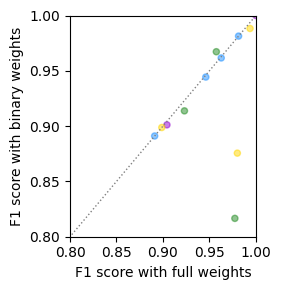

In [65]:

fig, axs = plt.subplots(1, 1, figsize=(3, 3))


x, y = f2, f

axs.scatter(x,y,
            s=20, color=colors, alpha=.5, marker="o")#, label="success")
axs.set_xlabel("F1 score with full weights")
axs.set_ylabel("F1 score with binary weights")


axs.plot([0, 1], [0, 1], linewidth=1, color="grey", linestyle=':' )

plt.xlim(.8,1)
plt.ylim(.8,1)

plt.tight_layout()

plt.savefig("../figures/S4_Weights-F1-compared.pdf", dpi=300)

In [3]:
f = []
f2 = []
colors = []
for p in all_patients:
    
    prefix = "AML_MutaSeq" if p[0]=="P" else "AML_10X" if p[0]=="A" else "LUNG" if p in LUNG_patients else "CRC"
    adata = anndata.read_h5ad("../processed_data/"+prefix+"/"+p+".h5ad")
    
    if ("cell_labels" not in adata.obs.columns) | ("ref_assignments" not in adata.obsm.keys()):
        continue
    all_f2 = []
    all_f = []
    colors.append("darkviolet" if p in AML_S2_patients else "forestgreen" if p in AML_10X_patients else "gold" if p in LUNG_patients else "dodgerblue")
    for s in ["False_2", "False_5", "False_10", "False_15", "True_2", "True_5", "True_10", "True_15"]:
        
        adata = anndata.read_h5ad("../processed_data/"+prefix+"/"+p+".h5ad")
        sub_cells = adata.obs_names[adata.obs["cell_labels"]!="undetermined"]
        try:
            subdata = anndata.read_h5ad("../../../runs/k"+str(adata.obsm["C"].shape[1])+"_"+p+"_"+s+".h5ad")
            idx = np.intersect1d(sub_cells, subdata.obs_names)
            subdata=subdata[idx]
            adata = adata[idx]


            cancer_factors = np.where(adata.uns['factor_labels']=="cancer")[0]
            ref_labels = np.array([i in cancer_factors for i in  np.argmax(adata.obsm["C"], axis=1)])

            if p[0]=="P":
                ref_cancer = (np.array(adata.obsm["ref_assignments"]["PhiSICShealthy"]<0.5 if p in ["P1", "P2"] else adata.obsm["ref_assignments"]["cancer_final"]))
            elif p in AML_10X_patients:
                ref_cancer = np.array(adata.obsm["ref_assignments"]["Healthy"]<0.5)
            elif p in LUNG_patients:
                ref_cancer = np.array(adata.obsm["ref_assignments"]["cna_clone"]=="CNA")
            else:
                ref_cancer = np.array(adata.obsm["ref_assignments"]["consensus_call"]=="genomically_tumour")
            sub = ~np.isnan(ref_cancer)

            

            C, V = subdata.obsm["C"], subdata.varm["V"]

            perm = list(permutations(np.arange(0, C.shape[1])))
            dists = [np.sum(np.abs((adata.obsm["C"]-C[:,perm[i]]))) for i in range(len(perm))]
            idx = perm[np.argmin(dists)]

            aligned_C = C[:,idx]
            new_labels = np.array([i in cancer_factors for i in np.argmax(aligned_C, axis=1)])
            all_f.append(sklearn.metrics.f1_score(ref_labels[sub], ref_cancer[sub]))
            all_f2.append(sklearn.metrics.f1_score(ref_cancer[sub], new_labels[sub]))
        except:
            print(p, s)
        
    f2.append(all_f2), f.append(all_f)


A2 True_15
p007 True_15
p014 False_15
p014 True_15


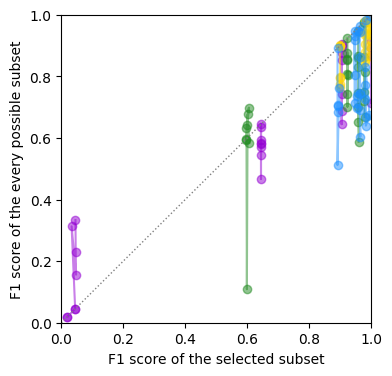

In [5]:
plt.subplots(1, 1, figsize=(4,4))
for i in range(len(f)):
    plt.plot(f[i], f2[i],'-o', color=colors[i], alpha=.5)
plt.xlim(0, 1)
plt.plot([0, 1], [0, 1], linewidth=1, color="grey", linestyle=':' )

plt.ylim(0, 1)

plt.ylabel("F1 score of the every possible subset")
plt.xlabel("F1 score of the selected subset")

plt.savefig("../figures/S21_variant-selection.png", dpi=300)